In [199]:
import numpy as np
import matplotlib.pyplot as plt
import numexpr as ne
import poppy
import timeit
from scipy.special import erfc
from numba import njit

# Propogate Divergence & Waist Rays of Gaussian Beamlets - NONastigmatic beamlets

# Wavefront Parameters
wl = 2.2e-6  # wavelength
OF = 1 # beamlet overlap factor
wo = 10*wl
#N  = 50 # Number of beamlets to trace    

# Generate Poppy aperture
amax = 5e-3     # meters
ap = poppy.CircularAperture(radius=amax)

# Detector Parameters
sample = 256       # number of detector pixels across

# Calculate Gaussian Beamlet Parameters
#wo = amax*OF/(2*N)
N = round((amax*OF/(2*wo))*12)
print(wo,'mm beam waist')
print(wo/wl,'waves beam waist')
print(N,' Number of Beamlets')

zr = np.pi*wo**2/wl # rayleigh range
k  = 2*np.pi/wl # wave number

# System Parameters
d   = 5e-3     # propagation distance
f   = 5e-3    # focal length
n   = 1       # refractive index 

# configure detector dimensions
u   = np.linspace(-amax,amax,sample)
v   = u

# Define a Q Matrix - diagonal zero for nonastigmatic case
qxx = 1/(1j*zr)
qxy = 0
qyx = 0
qyy = 1/(1j*zr)
Q = np.array([[qxx,qxy],
             [qyx,qyy]],dtype='complex') # Defines the matrix of inverse q parameters

print(amax**2/(d*wl),' Fresnel Number')
print(d/(2*amax),' Working F/#')
print(1.22*wl*(d/(2*amax)),'Airy Radius')

2.2e-05 mm beam waist
10.0 waves beam waist
1364  Number of Beamlets
2272.7272727272725  Fresnel Number
0.5  Working F/#
1.342e-06 Airy Radius


In [200]:
# Generate fibbonacci spaced list of xy center rays
r = amax
c = np.array([0,0]) # XY offset from a spiral
R = r*np.sqrt(np.linspace(1/2,N-1/2,N))/np.sqrt(N-1/2)
T = 4/(1+np.sqrt(5))*np.pi*np.linspace(1,N,N);
X = c[0] +R*np.cos(T)
Y = c[1] +R*np.sin(T)

#X = np.linspace(-amax,amax,N)
#Y = np.linspace(-amax,amax,N)
#print(X)

In [201]:
# Configure Propagation

# prepare array of base rays
base = np.array([[X],
                 [Y],
                 [0*X],
                 [0*Y]])

# prepare system matrix
focus = np.array([[1,0,0,0],
                  [0,1,0,0],
                  [-1/f,0,1,0],
                  [0,-1/f,0,1]])

propg = np.array([[1,0,d,0],
                 [0,1,0,d],
                 [0,0,1,0],
                 [0,0,0,1]])

system = np.matmul(propg,focus)

# propagate X and Y projections of rays
#x_ray = base*X
#y_ray = base*Y
#x_prp = np.matmul(system,x_ray)
#y_prp = np.matmul(system,y_ray)

#tbox = np.sqrt(np.square(x_prp[0,:]-x_ray[0,:])+np.square(y_prp[0,:]-y_ray[0,:])+d**2)
prop = (np.matmul(system,base[:,0]))
tbox = np.sqrt(np.square(prop[0,:]-base[0,:]) + np.square(prop[1,:]-base[1,:]) + d**2)

# propagate Q Parameter
A = system[0:2,0:2]
B = system[0:2,2:4]
C = system[2:4,0:2] # factor of 2 disparity on this matrix
D = system[2:4,2:4]

u,v = np.meshgrid(u,v)

In [202]:
# Define Gaussian & Half-Gaussian Beamlet w/Qprop

def Qprop(system,Q):
    
    # Prepare complex curvature matrix
    Qn = (C + np.matmul(D,Q)) # matrix numerator
    Qd = np.linalg.inv(A + np.matmul(B,Q)) # matrix denominator
    Qp = np.matmul(Qn,Qd) # propagated complex curvature
    
    return Qp

def GauBlet(system,Qp,Q,u,uo,v,vo):
    # Set up Electric Field Expression with detector dimensions
    u = u+uo
    v = v+vo
    Gamp = np.exp(-1j*k*d)/np.sqrt(np.linalg.norm(A+np.matmul(B,Q)))
    rQmult = Qp[0,0]*u**2 + (Qp[0,1]+Qp[1,0])*u*v + Qp[1,1]*v**2
    Gphase = np.exp((-1j*k/2)*rQmult)
    Efield = Gamp*Gphase
    
    return Efield

def GauBphase(system,Qp,Q,u,uo,v,vo):
    # Set up Electric Field Expression with detector dimensions
    u = u+uo
    v = v+vo
    Gphase = (-1j*k/2)*(-1j*k*d)*(Qp[0,0]*u**2 + (Qp[0,1]+Qp[1,0])*u*v + Qp[1,1]*v**2)
    
    return Gphase
    

def HGauBlet(system,Qp,Q,u,v):
    
    # Set up Electric Field Expression with detector dimensions
    A = system[0:2,0:2]
    B = system[0:2,2:4]
    u,v = np.meshgrid(u,v)
    Gamp = np.exp(-1j*k*d)/np.sqrt(np.linalg.norm(A+np.matmul(B,Q)))
    rQmult = Qp[0,0]*u**2 + (Qp[0,1]+Qp[1,0])*u*v + Qp[1,1]*v**2
    Gphase = np.exp((-1j*k/2)*rQmult)
    Hgaubamp = .5*erfc(-np.sqrt((1j*k)/(2*B[0,0]*(A[0,0] + B[0,0]*Q[0,0])))*u)
    Efield = Gamp*Gphase*Hgaubamp
    Ifield = np.real(Efield*np.conj(Efield))
    
    return Ifield

In [154]:
%%time

Dfield = np.zeros([sample,sample,N],dtype='complex')
Qp = Qprop(system,Q)
# try populate a circular aperture with beamlets

@njit
def dphase_loop(N,Dfield,system,Qp,Q,u,X,v,Y):
    for ind in range(N):
        uo = X[ind]
        vo = Y[ind]
        u = u+uo
        v = v+vo
        Gphase = (-1j*k/2)*(-1j*k*d)*(Qp[0,0]*u**2 + (Qp[0,1]+Qp[1,0])*u*v + Qp[1,1]*v**2)
        Dfield[:,:,ind] = Gphase
        
    return Dfield

Dfield = dphase_loop(N,Dfield,system,Qp,Q,u,X,v,Y)

Wall time: 4.15 s


In [203]:
%%time

Dfield = np.zeros([sample,sample,N],dtype='complex')
Qp = Qprop(system,Q)
# try populate a circular aperture with beamlets

@njit
def dphase_loop(N,Dfield,system,Qp,Q,u,X,v,Y):
    for ind in range(N):
        u = u+X[ind]
        v = v+Y[ind]
        rQmult = Qp[0,0]*u**2 + (Qp[0,1]+Qp[1,0])*u*v + Qp[1,1]*v**2
        Gphase = np.exp((-1j*k/2)*rQmult)
        Efield = Gamp*Gphase
        
        Dfield[:,:,ind] = Efield
        
    return Dfield

Dfield = np.exp(-1j*k*d)/np.sqrt(np.linalg.norm(A+np.matmul(B,Q)))*dphase_loop(N,Dfield,system,Qp,Q,u,X,v,Y)
Efield = np.sum(Dfield,axis=2,dtype=complex)

Wall time: 11 s


In [138]:
%%time
# compute exponential of cube numexpr
Dfield_ne = ne.evaluate('exp(Dfield)')

Wall time: 22.7 s


In [139]:
%%time
# compute exponential of cube numba
#@njit(fastmath=True)
#def numbaexp(Dfield):
#    Dfield_nu = np.exp(Dfield)
    
#    return Dfield_nu

#Dfield_nb = numbaexp(Dfield)

Wall time: 0 ns


In [140]:
%%time
# sum em up 
Efield = np.sum(Dfield_ne,axis=2,dtype=complex)
print(np.shape(Efield))

(500, 500)
Wall time: 1.2 s


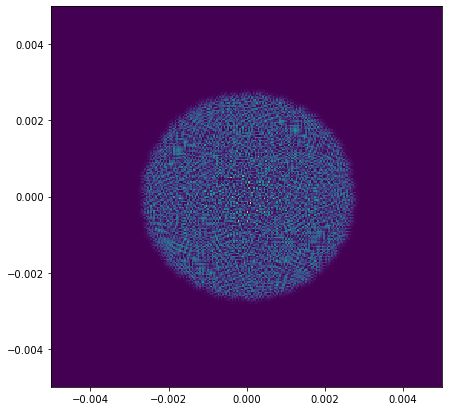

In [204]:
plt.figure(figsize=[7,7])
plt.pcolor(u,v,np.real(Efield*np.conj(Efield)))